<a href="https://colab.research.google.com/github/dionatrafk/model_evaluation/blob/master/GRU_exec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gated Recurrent Unit (GRU)

In [0]:
#Import datasets
!git clone https://github.com/dionatrafk/model_evaluation

*Execution options: **default 60 minute predictions.

**Copy a row of hyperparameters and paste into row 2 of the next cell.**

'trace1.csv', 140, 150, 8, 64 \
'trace5.csv', 130, 130, 128, 64 \
'trace10.csv', 140, 100, 16, 32 \
'trace15.csv', 140, 190, 5, 40 \
'trace20.csv', 140, 200, 50, 45 \
'trace25.csv', 180, 200, 10, 80 \
'trace30.csv', 140, 190, 5, 40  \
'trace35.csv', 180, 200, 10, 80 \
'trace40.csv', 130, 130, 256, 32 \
'trace45.csv', 140, 150, 8, 64 \
'trace50.csv', 130, 130, 60, 60 \
'trace55.csv', 130, 130, 128, 64 \
'trace60.csv', 130, 130, 128, 64 

In [0]:
#definir hiperparâmetros
filename, BATCH_SIZE, NB_EPOCHS, LAYER1, LAYER2 = 'trace60.csv', 130, 130, 128, 64

path = 'model_evaluation/http_requests_nasa/'
filename = path + filename



Compilation Time :  0:00:00.026881
Training time :  0:00:09.964370
Samples 438
Trainscore: 285.21
Test time:  0:00:00.011559
Timer:  0:00:10.965772
Filename: model_evaluation/http_requests_nasa/trace60.csv
BATCH_SIZE: 130
NB_EPOCHS:  130
LAYER1:  128
LAYER2:  64
R2:  0.843687465336718
Testscore: 272076.31 MSE (521.61 RMSE)


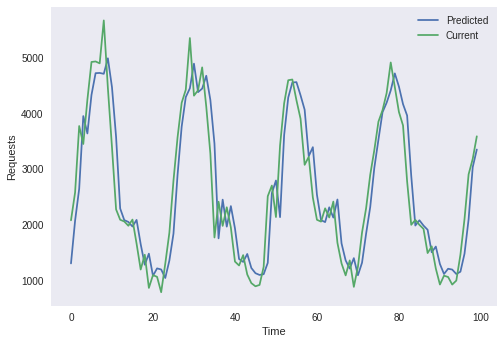

In [16]:
import pandas as pd
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import GRU
from keras.models import Sequential, load_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import math, datetime
import os, sys

def create_dataset(dataset, lookback=1):
    dataX, dataY = [], [] # create 2 empty lists

    # go through the lenght of dataset, subtract the lookback and 1. 2 steps before the end of dataset, 
    #because we predict 1 step to the future
    for i in range(len(dataset)-lookback-1):
        a = dataset[i:(i+lookback),0]
        dataX.append(a)
        dataY.append(dataset[i+lookback,0]) # get the next value
    return np.array(dataX), np.array(dataY)

#perc = float(sys.argv[6])
# Dataset configuration
dataset = pd.read_csv(filename, usecols = [1], header=None)
dataset.columns = ["request"]
dataset = dataset.values #convert to the array
dataset = dataset.astype('float32') # convert to float

# length of our dataset
training_size = int(len(dataset)*0.67)
testing_size = len(dataset)-training_size

# split the data set
train, test = dataset[0:training_size:], dataset[training_size:len(dataset),:]

# one time step to the future
lookback = 1
trainX, trainY = create_dataset(train, lookback)
testX, testY = create_dataset(test, lookback)

# Scaling dataset
x_train, y_train = trainX, trainY 
x_test, y_test = testX, testY

# scaling values for model
scaleX = MinMaxScaler()
scaleY = MinMaxScaler()

trainX = scaleX.fit_transform(x_train)
trainX = trainX.reshape((-1,1,1))

trainY = scaleY.fit_transform(y_train.reshape(-1,1))

testX  = scaleX.fit_transform(x_test)
testX = testX.reshape((-1,1,1))

testY  = scaleY.fit_transform(y_test.reshape(-1,1))

# creating model using Keras
model_name = 'requests_GRU'
model = Sequential()
model.add(GRU(units=LAYER1,
              return_sequences=True,
              input_shape=(1, 1)))
model.add(Dropout(0.2))
model.add(GRU(units=LAYER2))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

#test with less samples	
#size = int(training_size * (perc /100))
#trainX = trainX[0:training_size - size:]
#trainY = trainY[0:training_size - size:]
timer = datetime.datetime.now() 
# Compilation and training
start = datetime.datetime.now() 
model.compile(loss='mean_squared_error', optimizer='adam')


print ''
print "Compilation Time : ",  datetime.datetime.now()  - start
start = datetime.datetime.now() 
model.fit(trainX,trainY,batch_size=BATCH_SIZE, epochs=NB_EPOCHS, validation_split=0.1, verbose=0)
print "Training time : ",  datetime.datetime.now()  - start
#model.save("{}.h5".format(model_name))

# Making predictions
yhat = model.predict(trainX)
yhat = scaleX.inverse_transform(yhat)
y_test = scaleX.inverse_transform(trainY)

print "Samples",len(trainY)

train_score = mean_squared_error(y_test, yhat)

print ('Trainscore: %.2f' %(math.sqrt(train_score)))

start = datetime.datetime.now() 

yhat = model.predict(testX)
print "Test time: ", datetime.datetime.now() -start

print "Timer: ",  datetime.datetime.now()  - timer
yhat = scaleY.inverse_transform(yhat)
y_test = scaleY.inverse_transform(testY)

#RMSE score
test_score = mean_squared_error(y_test, yhat)
#R square score
r2 = r2_score(y_test,yhat)

print'Filename:',filename
print'BATCH_SIZE:',BATCH_SIZE
print'NB_EPOCHS: ',NB_EPOCHS
print'LAYER1: ',LAYER1
print'LAYER2: ',LAYER2 

print'R2: ',r2

print ('Testscore: %.2f MSE (%.2f RMSE)' %(test_score, math.sqrt(test_score)))

# plot some samples.
plt.plot(yhat[-100:], label='Predicted')
plt.plot(y_test[-100:], label='Current')
plt.legend()
plt.grid()

plt.ylabel('Requests')
plt.xlabel('Time')
plt.show()